In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container {width:100% !important; }</style>"))

In [2]:
from pathlib import Path
import time

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import numpy as np

import tensorly as tl

In [3]:
%load_ext autoreload
%autoreload 2
import bnpm

Import data

In [4]:
directory_data_tca = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/fr_run/run_20230903/'

In [5]:
paths_data_tca = bnpm.path_helpers.find_paths(
    dir_outer=directory_data_tca,
    reMatch='VQT_Analyzer.h5',
    depth=7,
    natsorted=True,
)

### MANUAL EDITING ###
paths_data_tca = np.array(paths_data_tca)
# paths_data_tca = np.delete(paths_data_tca, 0)
# paths_data_tca = np.delete(paths_data_tca, 15)

dates_data_tca = [Path(p).parts[-4] for p in paths_data_tca]

list(dates_data_tca)

['20230703',
 '20230705',
 '20230706',
 '20230707',
 '20230708',
 '20230709',
 '20230710',
 '20230711',
 '20230712',
 '20230713',
 '20230714',
 '20230715',
 '20230716',
 '20230717',
 '20230718',
 '20230719',
 '20230720',
 '20230721',
 '20230722',
 '20230723',
 '20230724',
 '20230725',
 '20230726',
 '20230727',
 '20230728',
 '20230729',
 '20230730',
 '20230731',
 '20230801',
 '20230802',
 '20230803',
 '20230804',
 '20230805',
 '20230806',
 '20230807',
 '20230808',
 '20230809',
 '20230811']

In [6]:
data_tca = {d: bnpm.h5_handling.simple_load(p, return_dict=False,) for d,p in tqdm(zip(dates_data_tca, paths_data_tca))}

0it [00:00, ?it/s]

make a subsampled and concatenated version

In [7]:
n_samples_per_session = 1000

spectrograms_subsampled = {}

for date, data in tqdm(data_tca.items()):
    idx = np.sort(np.random.choice(np.arange(data['spectrograms']['0'].shape[-1]), size=min(n_samples_per_session, data['spectrograms']['0'].shape[-1]), replace=False))

    spectrograms_subsampled[date] = torch.as_tensor(data['spectrograms']['0'][:])[..., idx]

  0%|          | 0/38 [00:00<?, ?it/s]

In [8]:
DEVICE_bigTCA = bnpm.torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [9]:
spectrograms_cat = np.concatenate(list(spectrograms_subsampled.values()), axis=-1)

In [10]:
spectrograms_cat = spectrograms_cat.transpose(-1, 2, 0, 1)
spectrograms_cat = spectrograms_cat.reshape(spectrograms_cat.shape[0], spectrograms_cat.shape[1], -1)
spectrograms_cat = torch.as_tensor(spectrograms_cat, dtype=torch.float32, device=DEVICE_bigTCA)

In [11]:
np.save('/media/rich/bigSSD/downloads_tmp/spec_cat.npy', spectrograms_cat.cpu().numpy())

In [ ]:
spectrograms_cat = np.load('/media/rich/bigSSD/downloads_tmp/spec_cat.npy')
spectrograms_cat = torch.as_tensor(spectrograms_cat, dtype=torch.float32, device=DEVICE_bigTCA)

In [18]:
bnpm.misc.estimate_array_size(spectrograms_cat)

/tmp/ipykernel_4115797/3210189866.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  bnpm.misc.estimate_array_size(spectrograms_cat)


10.23264

In [19]:
bnpm.torch_helpers.clear_cuda_cache()

In [20]:
tl.set_backend('pytorch')

In [21]:
model = tl.decomposition.CP_NN_HALS(
    rank=10,
    n_iter_max=100,
    init='random',
    svd='truncated_svd',
    tol=1e-07,
    sparsity_coefficients=None,
    fixed_modes=None,
    nn_modes='all',
    exact=False,
    verbose=True,
#     normalize_factors=False,
#     cvg_criterion='abs_rec_error',
#     random_state=None,
)

In [22]:
tic = time.time()
model.fit(spectrograms_cat)
print(time.time() - tic)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/roicat/lib/python3.11/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.6095482110977173
iteration 1, reconstruction error: 0.5083190202713013, decrease = 0.10122919082641602
iteration 2, reconstruction error: 0.4959201216697693, decrease = 0.012398898601531982
iteration 3, reconstruction error: 0.49133414030075073, decrease = 0.004585981369018555
iteration 4, reconstruction error: 0.4890895187854767, decrease = 0.002244621515274048
iteration 5, reconstruction error: 0.48771148920059204, decrease = 0.0013780295848846436
iteration 6, reconstruction error: 0.4867868721485138, decrease = 0.0009246170520782471
iteration 7, reconstruction error: 0.48614007234573364, decrease = 0.0006467998027801514
iteration 8, reconstruction error: 0.4856703281402588, decrease = 0.0004697442054748535
iteration 9, reconstruction error: 0.48531585931777954, decrease = 0.00035446882247924805
iteration 10, reconstruction error: 0.48503729701042175, decrease = 0.0002785623073577881
iteration 11, reconstruction error: 0.4848134219646454, decrease = 0.000223875

In [23]:
factors = model.decomposition_.factors

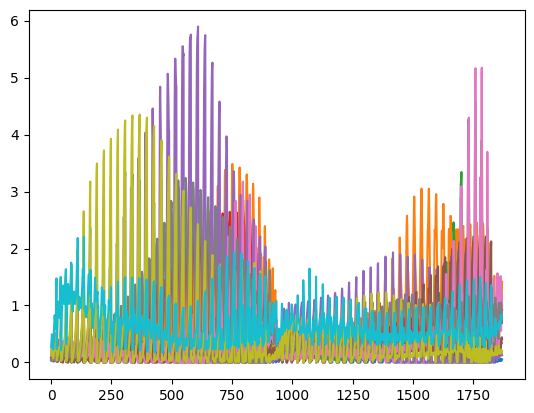

In [24]:
plt.figure()
plt.plot(factors[2].cpu())

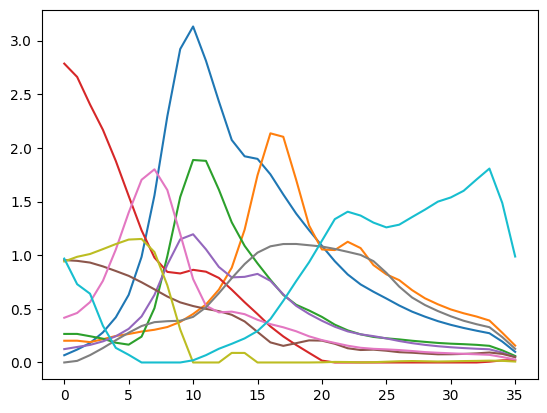

In [25]:
plt.figure()
plt.plot(factors[1].cpu())

rearrange factors

In [27]:
factors_named = {
    'time': factors[0].cpu(),
    'frequency': factors[1].cpu(),
    '(points (xy))': factors[2].cpu(),
}

Save factors

In [28]:
bnpm.h5_handling.simple_save(
    dict_to_save=factors_named,
    path=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/fr_run/bigTCA.h5',
    write_mode='w',
)

In [7]:
factors_named = bnpm.h5_handling.simple_load(
    filepath=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/fr_run/bigTCA.h5',
)

refit temporal factor for each day

In [8]:
DEVICE_smallTCA = bnpm.torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [9]:
tl.set_backend('pytorch')

In [10]:
init_bt = tl.cp_tensor.CPTensor((None, [torch.as_tensor(factors_named[key], dtype=torch.float32, device='cpu') for key in ['time', 'frequency', '(points (xy))']]))

In [11]:
import copy

In [12]:
bnpm.torch_helpers.clear_cuda_cache()

In [ ]:
factors_refit = {}
for date, data in tqdm(data_tca.items()):
    data_rs = torch.as_tensor(data['spectrograms']['0'][:], dtype=torch.float32, device='cpu')
    
    data_rs = data_rs.permute(-1, 2, 0, 1)
    data_rs = data_rs.reshape(data_rs.shape[0], data_rs.shape[1], -1).permute(1,2,0)
    data_rs = data_rs.to(DEVICE_smallTCA)
    
    init_bt_i = copy.deepcopy(init_bt).factors
    init_bt_i[0] = init_bt_i[0][torch.randint(low=0, high=init_bt_i[0].shape[0], size=(data_rs.shape[2],)), :]
    init_bt_i = [torch.as_tensor(t, dtype=torch.float32, device=DEVICE_smallTCA) for t in init_bt_i]
    init_bt_i = [init_bt_i[ii] for ii in [1,2,0]]

    model = tl.decomposition.CP_NN_HALS(
        rank=10,
        n_iter_max=100,
#         init='random',
        init=tl.cp_tensor.CPTensor((None, init_bt_i)),
        svd='truncated_svd',
        tol=1e-08,
        sparsity_coefficients=None,
        fixed_modes=[0,1],
        nn_modes='all',
        exact=False,
        verbose=True,
    #     normalize_factors=False,
    #     cvg_criterion='abs_rec_error',
    #     random_state=None,
    )
    
    model.fit(tensor=data_rs)
    
    factors_refit[date] = copy.deepcopy([f.cpu().numpy() for f in model.decomposition_.factors])
    
    del data_rs
    bnpm.torch_helpers.clear_cuda_cache()

  0%|          | 0/38 [00:00<?, ?it/s]

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/roicat/lib/python3.11/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.4850618839263916
iteration 1, reconstruction error: 0.4850618839263916, decrease = 0.0
PARAFAC converged after 1 iterations
reconstruction error=0.5111635327339172
iteration 1, reconstruction error: 0.5111632943153381, decrease = 2.384185791015625e-07
iteration 2, reconstruction error: 0.5111632943153381, decrease = 0.0
PARAFAC converged after 2 iterations


In [ ]:
factors_refit_named = {date: {
    '(xy points)': f[1],
    'frequency': f[0],
    'time': f[2],
} for date, f in factors_refit.items()}

In [ ]:
factors_refit_separated = {date: {'factors_rearranged': {'0': f}} for date, f in factors_refit_named.items()}

In [ ]:
bnpm.h5_handling.simple_save(
    dict_to_save=factors_refit_named,
    path=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/fr_run/factors_refit_bigTCA.h5',
    write_mode='w'
)

In [ ]:
[bnpm.h5_handling.simple_save(
    dict_to_save=f,
    path=f'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/fr_run/factors_refit/{date}/TCA.h5',
    write_mode='w',
) for date, f in factors_refit_separated.items()];

visualize

In [21]:
%load_ext autoreload
%autoreload 2
import face_rhythm as fr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
directory_data_vqt = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/'

paths_data_vqt = bnpm.path_helpers.find_paths(
    dir_outer=directory_data_vqt,
    reMatch='VQT_Analyzer.h5',
    depth=7,
    natsorted=True,
)
dates_data_vqt = [Path(p).parts[-4] for p in paths_data_vqt]

dates_data_vqt

['20230703',
 '20230705',
 '20230706',
 '20230707',
 '20230708',
 '20230709',
 '20230710',
 '20230711',
 '20230712',
 '20230713',
 '20230714',
 '20230715',
 '20230716',
 '20230717',
 '20230718',
 '20230719',
 '20230720',
 '20230721',
 '20230722',
 '20230723',
 '20230724',
 '20230725',
 '20230726',
 '20230727',
 '20230728',
 '20230729',
 '20230730',
 '20230731',
 '20230801',
 '20230802',
 '20230803',
 '20230804',
 '20230805',
 '20230806',
 '20230807',
 '20230808',
 '20230809',
 '20230811']

In [24]:
data_vqt = {d: bnpm.h5_handling.simple_load(p, return_dict=False,) for d,p in tqdm(zip(dates_data_vqt, paths_data_vqt))}

0it [00:00, ?it/s]

In [25]:
data_pts = {d: bnpm.h5_handling.simple_load(str(Path(p).parent / 'PointTracker.h5'), return_dict=False,) for d,p in tqdm(zip(dates_data_vqt, paths_data_vqt))}

0it [00:00, ?it/s]

In [26]:
tca = bnpm.h5_handling.simple_load(
    filepath=r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/fr_run/factors_refit_bigTCA.h5',
    return_dict=True,
)

In [29]:
eye_masks = bnpm.file_helpers.pickle_load(r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/eye_laser_trace_extraction/masks/eye_masks.pkl')

In [30]:
image = eye_masks['images']['/mnt/MICROSCOPE/Gyu/BMI_data/cage_0403/mouse_0403L/20230703/camera_data/exp/cam4/cam42023-07-03T09_49_20.avi']


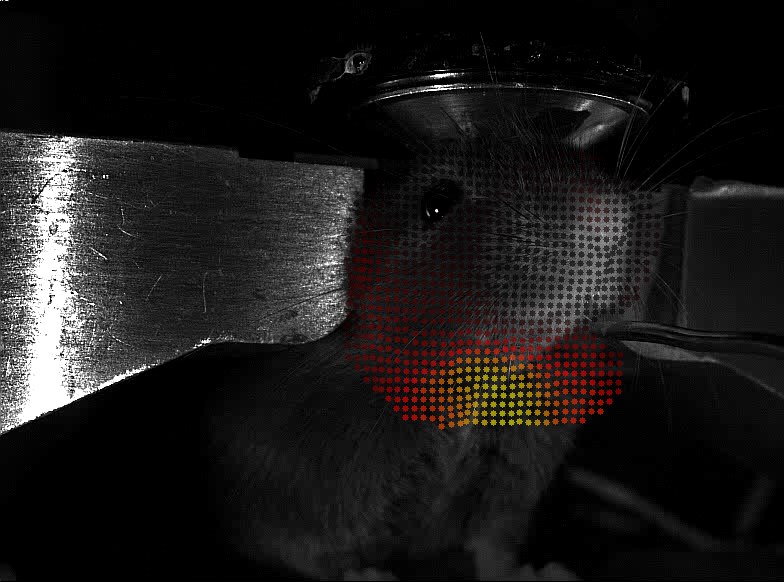

In [31]:
date = '20230703'

cmap = fr.helpers.simple_cmap(
    colors=[[0,0,0], [1,0,0], [1,1,0]], 
    over=[0,1,0], 
    under=[0,1,0], 
    bad=[0,1,0], 
)

factor_values = tca[date]['(xy points)'][:]
factor_magnitudes = np.linalg.norm(factor_values.reshape(2, factor_values.shape[0]//2, -1), axis=0)

pts_tmp = data_pts[date]['point_positions'][:]
im_tmp = image

frame_visualizer = fr.visualization.FrameVisualizer(
    verbose=2,
    frame_height_width=im_tmp.shape[:2],
    point_sizes=3,
    alpha=0.6,
)

ims_factors_points = [frame_visualizer.visualize_image_with_points(image=im_tmp, points=pts_tmp, points_colors=[(cmap(f/f.max())*255).astype(np.int64)[:,:3]]) for f in factor_magnitudes.T] 

fr.visualization.display_toggle_image_stack(ims_factors_points)

In [39]:
# Save images
import PIL
dir_save = r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/fr_run/factor_ims'
Path(dir_save).mkdir(parents=True, exist_ok=True)

[PIL.Image.fromarray(im).save(str(Path(dir_save) / f"factor_{ii}.jpg")) for ii, im in enumerate(ims_factors_points)];

In [ ]:
fig_tca_specFactor = plt.figure()
plt.plot(spec_data['frequencies'], tca_data['factors']['0']['frequency'])
plt.xscale('log')
plt.xlabel('frequency')
plt.legend(np.arange(tca_data['factors']['0']['frequency'].shape[1]) + 1);
plt.show()